# Result Analysis Test

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import math
from pathlib import Path
import os
from collections import defaultdict
from scipy.spatial.distance import cdist

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

color_dict = {"PP": "blue", "APP": "green", "RPP": "orange", "DWPP": "red"}

## Make reference path

In [36]:
from os import path


def make_iso_path():
    """
    Function to generate reference paths
    Returns:
        (path_A, path_B, path_C)
    """
    
    Lu = 0.985
    
    # Path A: 5*Lu straight line
    x_A = np.linspace(0, 5*Lu, 500)
    y_A = np.zeros_like(x_A)
    path_A = np.c_[x_A, y_A]
    
    # Path B: Square with side length 5*Lu
    x_B1 = np.linspace(0, 5*Lu, 500)
    y_B1 = np.zeros_like(x_B1)
    y_B2 = np.linspace(0, -5*Lu, 500)
    x_B2 = np.ones_like(y_B2) * 5 * Lu
    x_B3 = np.linspace(5*Lu, 0, 500)
    y_B3 = np.ones_like(x_B3) * -5 * Lu
    y_B4 = np.linspace(-5*Lu, 0, 500)
    x_B4 = np.zeros_like(y_B4)
    x_B = np.concatenate([x_B1, x_B2, x_B3, x_B4])
    y_B = np.concatenate([y_B1, y_B2, y_B3, y_B4])
    path_B = np.c_[x_B, y_B]
    
    # Path C: Straight line + arc
    x_C1 = np.linspace(0, 5*Lu, 500)
    y_C1 = np.zeros_like(x_C1)
    theta_list = np.linspace(0, np.pi/2, 500)
    x_C2 = 5*Lu*(1+np.sin(theta_list))
    y_C2 = 5*Lu*(np.cos(theta_list)-1)
    x_C = np.concatenate([x_C1, x_C2])
    y_C = np.concatenate([y_C1, y_C2])
    path_C = np.c_[x_C, y_C]
    
    path_dict = {
        "PathA": path_A,
        "PathB": path_B,
        "PathC": path_C
    }
    
    return path_dict

reference_path = make_iso_path()

## Transform position from map frame to path origin frame

In [37]:
# Transform pose to path origin
def transform_pose_to_path_origin(x, y, yaw, path_origin_x, path_origin_y, path_origin_yaw):
    # Translate
    x_translated = x - path_origin_x
    y_translated = y - path_origin_y
    # Rotate
    cos_yaw = math.cos(-path_origin_yaw)
    sin_yaw = math.sin(-path_origin_yaw)
    x_rotated = x_translated * cos_yaw - y_translated * sin_yaw
    y_rotated = x_translated * sin_yaw + y_translated * cos_yaw
    return x_rotated, y_rotated, yaw - path_origin_yaw

In [38]:
# Calculate RMSE between robot path and reference path
def calc_rmse(robot_path: np.ndarray, path: np.ndarray) -> float:

    # Compute the distances between each point on the robot trajectory and each point on the path at once (using scipy's cdist)
    # distance_matrix has shape = (number of points in the robot trajectory, number of points in the path)
    distance_matrix = cdist(robot_path, path, metric='euclidean')

    # Take the minimum along the row direction to extract the minimum distance for each robot point
    min_distances = np.min(distance_matrix, axis=1)

    # Compute RMSE
    rmse = np.sqrt(np.mean(min_distances**2))
    
    return rmse

In [39]:
# Plot velocity profile
def plot_velocity_profile(t, v_real, w_real, v_cmd, w_cmd, path_name, controller_name, data_dir):
    # Create subplots for translational and rotational velocities (horizontal layout)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

    # Plot translational velocity
    ax1.plot(t, v_cmd, '-', color='red', label='Reference', linewidth=1, alpha=0.8)
    ax1.plot(t, v_real, '-', color='blue', label='Actual', linewidth=1)
    # Add velocity limit line
    ax1.axhline(y=0.83, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')

    # Plot rotational velocity
    ax2.plot(t, w_cmd, '-', color='red', label='Reference', linewidth=1, alpha=0.8)
    # ax2.plot(timestamps, cmd_angular, '-', color='blue', label='Command', linewidth=3)
    ax2.plot(t, w_real, '-', color='blue', label='Actual', linewidth=1)
    # Add velocity limit lines
    ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')
    ax2.axhline(y=-1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Min Velocity')

    # Set labels and legends
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Linear Velocity [m/s]')
    # ax1.set_yticks([0, 0.10, 0.20])
    ax1.grid(True, alpha=0.3)
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Angular Velocity [rad/s]')
    # ax2.set_ylim(-0.7, 0.7)
    # ax2.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax2.grid(True, alpha=0.3)
    # ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    filename = data_dir / f"{path_name}_{controller_name}_velocity.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


In [40]:
# measure travel time
def measure_travel_time(timestamp):
    start_time = timestamp[0]
    end_time = timestamp[-1]
    travel_time = end_time - start_time
    return travel_time

In [41]:
# Plot path
def plot_path(csv_paths: list[Path], path_name: str, controller_names: list[str]):
    paths = []
    for csv_path in csv_paths:
        # read csv
        df = pd.read_csv(csv_path)
        data_dir = csv_path.parent
        
        # Extract relevant data
        map_base_x = df["map_base_x"].to_numpy()
        map_base_y = df["map_base_y"].to_numpy()
        map_base_yaw = df["map_base_yaw"].to_numpy()
        
        x, y, yaw = transform_pose_to_path_origin(map_base_x, map_base_y, map_base_yaw, map_base_x[0], map_base_y[0], map_base_yaw[0])
        path = np.vstack((x, y)).T
        paths.append(path)
    
    fig = plt.figure(figsize=(6.5,6.5))
    ax = fig.add_subplot(1, 1, 1)
    
    for path, controller_name in zip(paths, controller_names):
        x = path.T[0]
        y = path.T[1]
        # Plot robot trajectory (rotate: X->Y, Y->-X for X-up, Y-left coordinate system)
        ax.plot(y, [-x for x in x], color=color_dict[controller_name], label=controller_name, linewidth=1)

    ref_x = [point[0] for point in  reference_path[path_name]]
    ref_y = [point[1] for point in reference_path[path_name]]
    ax.plot(ref_y, [-x for x in ref_x], 'k--', label='Reference Path', linewidth=1, alpha=0.7)
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$y$ [m]')

    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.tight_layout()
    plt.legend()
    
    filepath = data_dir / 'path_comparison.png'

    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()


In [42]:
def analyze_single_csv(csv_path: Path, path_name: str, controller_name: str):
    # read csv
    df = pd.read_csv(csv_path)
    data_dir = csv_path.parent
    
    # Extract relevant data
    timestamp = df["sec"].to_numpy() + df["nsec"].to_numpy() * 1e-9
    timestamp -= timestamp[0]  # Normalize to start from zero
    v_now = df["v_now"].to_numpy()
    w_now = df["w_now"].to_numpy()
    v_cmd = df["v_cmd"].to_numpy()
    w_cmd = df["w_cmd"].to_numpy()
    actual_v = df["v_nav"].to_numpy()
    actual_w = df["w_nav"].to_numpy()
    v_real = df["v_real"].to_numpy()
    w_real = df["w_real"].to_numpy()
    dw_max_v = df["dw_v_max"].to_numpy()
    dw_max_w = df["dw_w_max"].to_numpy()
    dw_min_v = df["dw_v_min"].to_numpy()
    dw_min_w = df["dw_w_min"].to_numpy()
    v_reg = df["v_reg"].to_numpy()
    
    map_base_x = df["map_base_x"].to_numpy()
    map_base_y = df["map_base_y"].to_numpy()
    map_base_yaw = df["map_base_yaw"].to_numpy()
    
    x, y, yaw = transform_pose_to_path_origin(map_base_x, map_base_y, map_base_yaw, map_base_x[0], map_base_y[0], map_base_yaw[0])
    
    # calc RMSE
    path = reference_path[path_name]
    robot_path = np.vstack((x, y)).T
    rmse = calc_rmse(robot_path, path)
    print(f" RMSE to {path_name} of {controller_name}: {rmse:.4f} m")
    
    # calc travel time
    travel_time = measure_travel_time(timestamp)
    print(f" Travel time of {controller_name}: {travel_time:.2f} s")
    
    # plot velocity profile
    plot_velocity_profile(timestamp, v_real, w_real, v_cmd, w_cmd, path_name, controller_name, data_dir)
    

 RMSE to PathB of PP: 0.2051 m
 Travel time of PP: 24.27 s


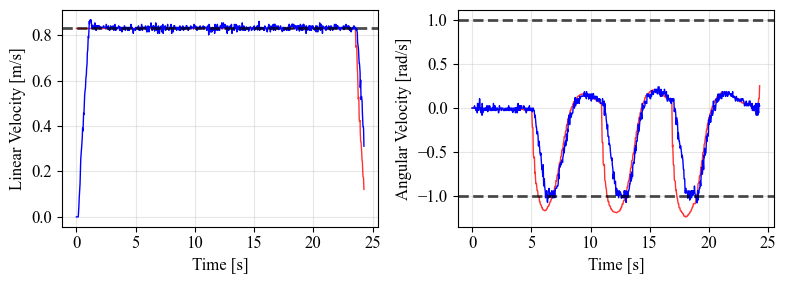

 RMSE to PathB of APP: 0.1727 m
 Travel time of APP: 23.36 s


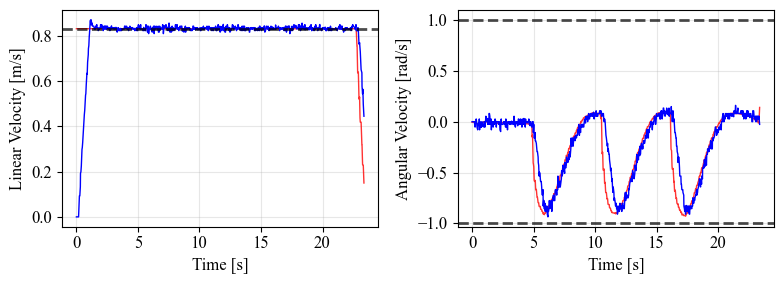

 RMSE to PathB of RPP: 0.0886 m
 Travel time of RPP: 26.20 s


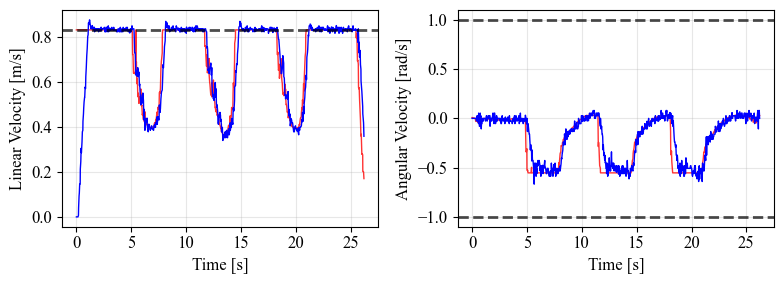

 RMSE to PathB of DWPP: 0.0644 m
 Travel time of DWPP: 29.63 s


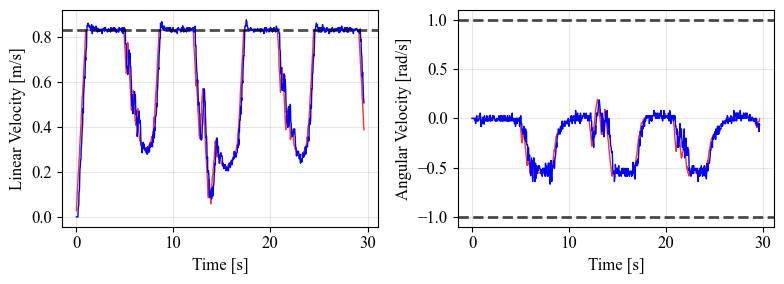

In [43]:
PP_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/iso_exp/PathB/PP/dynamic_window_pure_pursuit_log_20260111_155728_447855018.csv")
APP_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/iso_exp/PathB/APP/dynamic_window_pure_pursuit_log_20260111_160132_484387472.csv")
RPP_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/iso_exp/PathB/RPP/dynamic_window_pure_pursuit_log_20260111_160708_526115932.csv")
DWPP_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/iso_exp/PathB/DWPP/dynamic_window_pure_pursuit_log_20260111_161153_196356859.csv")

analyze_single_csv(PP_path, "PathB", "PP")
analyze_single_csv(APP_path, "PathB", "APP")
analyze_single_csv(RPP_path, "PathB", "RPP")
analyze_single_csv(DWPP_path, "PathB", "DWPP")

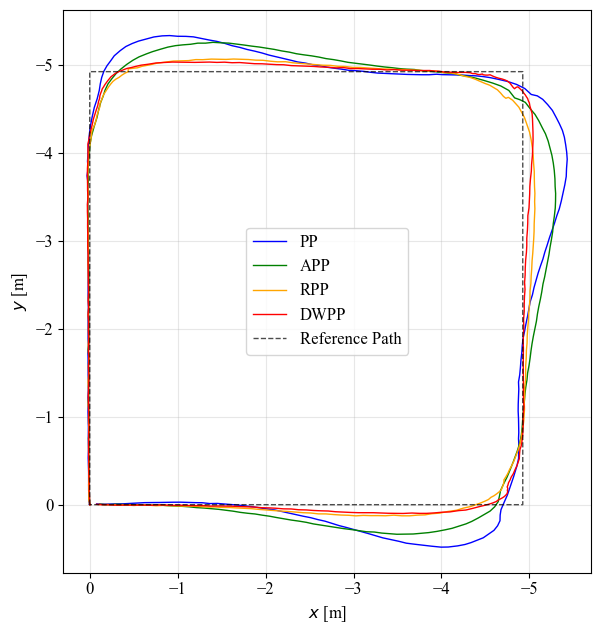

In [44]:
plot_path([PP_path, APP_path, RPP_path, DWPP_path], "PathB", ["PP", "APP", "RPP", "DWPP"])

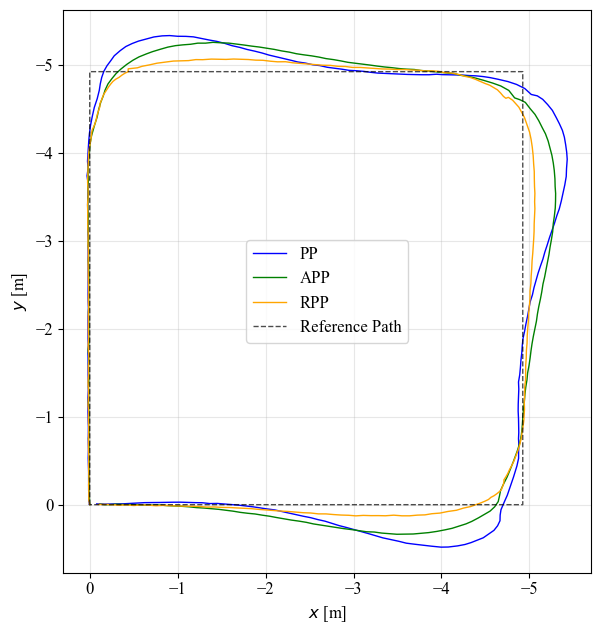

In [45]:
plot_path([PP_path, APP_path, RPP_path], "PathB", ["PP", "APP", "RPP"])